In [1]:
!pip install lightgbm
!pip install optuna

In [2]:
import sqlite3
import pandas as pd
import numpy as np

from datetime import datetime
from dateutil.relativedelta import relativedelta

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt 
import seaborn as sns # Import seaborn

from datetime import datetime
from datetime import date
from dateutil import parser

import lightgbm as lgb
from sklearn.metrics import accuracy_score
import optuna
from optuna.integration import OptunaSearchCV

from collections import defaultdict

import time

from warnings import simplefilter

In [3]:
simplefilter(action="ignore",category=FutureWarning)

In [4]:
pd.options.mode.chained_assignment = None

# Import pre-processed data frame
curr_date = "2023-04-19"
pickle_file = 'sa-preprocessing-' + curr_date + '.pkl'
pickle_file_path = 'data/' + pickle_file
df_main_nn = pd.read_pickle(pickle_file_path)

In [5]:
# Create the dataframe for modeling
feature_names = ["last_ten","last_five","last_three","away_player_height_average","away_player_height_average","home_player_weight_average",
              "away_player_weight_average",'home_player_age_average','away_player_age_average','home_player_rating_average','away_player_rating_average',
              'home_team_bmi' ,'away_team_bmi','goal_diff']
X = df_main_nn[feature_names].values
y = df_main_nn['outcome'].values

X_train,X_test,y_train,y_test = train_test_split(X,y)
pd.DataFrame(X).tail(100)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
20082,3.0,1.0,1.0,179.647273,179.647273,160.818182,164.090909,26.909091,25.363636,72.454545,72.454545,22.896039,23.062667,0.0
20083,3.0,1.0,0.0,183.803636,183.803636,165.636364,172.363636,27.181818,26.272727,71.545455,71.545455,23.400031,23.142150,0.0
20084,3.0,1.0,0.0,181.725455,181.725455,162.454545,168.636364,27.181818,28.727273,71.272727,71.272727,23.009790,23.162528,-1.0
20085,2.0,0.0,0.0,178.723636,178.723636,160.818182,166.363636,27.181818,25.363636,72.909091,72.909091,22.836914,23.624394,3.0
20086,3.0,1.0,1.0,181.032727,181.032727,160.636364,172.181818,28.090909,28.454545,72.545455,72.545455,22.811095,23.830840,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20177,2.0,0.0,0.0,182.187273,182.187273,167.000000,169.181818,24.090909,23.000000,65.818182,65.818182,22.763890,23.119790,-1.0
20178,1.0,0.0,0.0,181.725455,181.725455,167.181818,163.454545,24.818182,27.545455,65.636364,65.636364,22.846477,22.450795,-1.0
20179,1.0,0.0,0.0,185.189091,185.189091,167.818182,173.727273,26.000000,27.636364,66.272727,66.272727,22.817615,22.977536,0.0
20180,1.0,0.0,0.0,182.187273,182.187273,169.181818,166.454545,26.090909,25.090909,66.000000,66.000000,22.714948,22.747090,-1.0


Text(0, 0.5, 'Explained Variance')

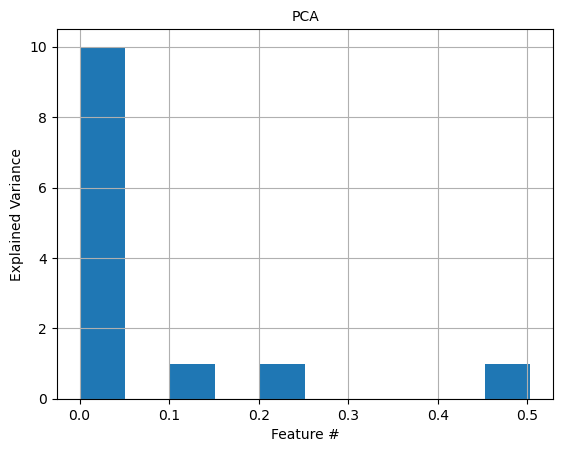

In [6]:
# PCA
from sklearn import preprocessing
from sklearn.decomposition import PCA

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

pca = PCA(n_components = 13)
pca.fit(X)

pca_evr = pd.DataFrame(pca.explained_variance_ratio_)

# Create a figure with two subplots
pca_evr.hist()
plt.title("PCA",fontsize=10)
plt.xlabel('Feature #',fontsize=10)
plt.ylabel('Explained Variance',fontsize=10)


In [7]:
# Baseline models
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()

decision_tree.fit(X_train, y_train)
random_forest.fit(X_train, y_train)

print(decision_tree.score(X_test, y_test))
print(random_forest.score(X_test, y_test))

1.0
1.0


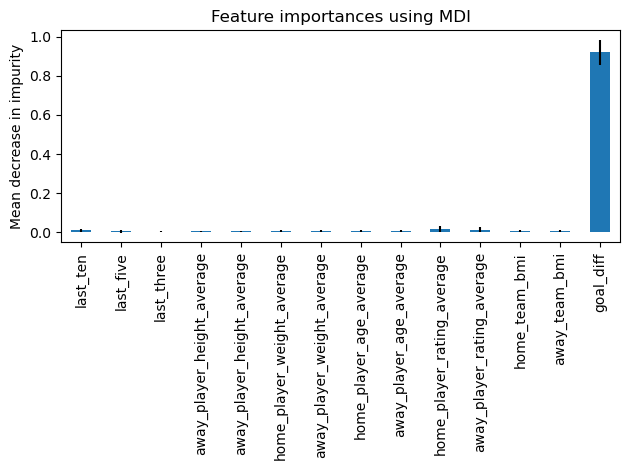

In [8]:
# Feature importance (RF) - based on mean decrease in impurity
importances = random_forest.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
std = np.std([tree.feature_importances_ for tree in random_forest.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)

ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

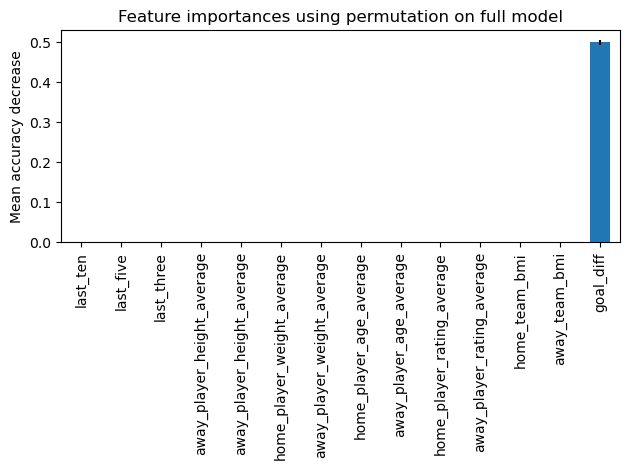

In [9]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    random_forest, X_test, y_test) # n_repeats=10, random_state=42, n_jobs=2

forest_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [10]:
# Logistic regression
from sklearn import linear_model

logistic_regression = linear_model.LogisticRegression()
logistic_regression.fit(X_train, y_train)

print(logistic_regression.score(X_test, y_test))

1.0


C:\Users\richt\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB

gauss_nb = GaussianNB()
gauss_nb.fit(X_train, y_train)

print(gauss_nb.score(X_test, y_test))

0.9120095124851367


In [12]:
# K nearest neighbor
from sklearn.neighbors import KNeighborsClassifier

k_neighbors = KNeighborsClassifier()
k_neighbors.fit(X_train, y_train)

print(k_neighbors.score(X_test, y_test))

0.8682124455013872


In [13]:
# Adaboost
from sklearn.ensemble import AdaBoostClassifier

ada_boost = AdaBoostClassifier(n_estimators = 200)
ada_boost.fit(X_train, y_train)

print(ada_boost.score(X_test, y_test))

1.0


In [14]:
# Gradient Boost Classifier
from sklearn.ensemble import GradientBoostingClassifier

gradient_boost = GradientBoostingClassifier()
gradient_boost.fit(X_train, y_train)

print(gradient_boost.score(X_test, y_test))

1.0


In [15]:
# Define the objective function
def objective(trial):
    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'random_state': 42
    }
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [16]:
# Define the search space using IntLogUniformDistribution
search_space = {
    'num_leaves': optuna.distributions.IntLogUniformDistribution(2, 256),
    'learning_rate': optuna.distributions.LogUniformDistribution(0.001, 0.1),
    'max_depth': optuna.distributions.IntUniformDistribution(3, 10),
    'feature_fraction': optuna.distributions.UniformDistribution(0.1, 1.0),
    'bagging_fraction': optuna.distributions.UniformDistribution(0.1, 1.0),
    'bagging_freq': optuna.distributions.IntUniformDistribution(1, 10),
    'min_child_samples': optuna.distributions.IntUniformDistribution(5, 100),
}

# Create a study object and run the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Train the final model with the best hyperparameters
best_params = study.best_params
model = lgb.LGBMClassifier(**best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_lgbm = accuracy_score(y_test, y_pred)

# Print the results
print('Best accuracy:', study.best_value)
print('Best parameters:', study.best_params)
print('Accuracy on test data:', accuracy_lgbm)

[I 2023-04-19 13:29:20,818] A new study created in memory with name: no-name-e183151e-ba4e-4b42-9524-94c33564a520


[LightGBM] [Warning] feature_fraction is set=0.21766653370064615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21766653370064615
[LightGBM] [Warning] bagging_fraction is set=0.7092149789929059, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7092149789929059
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-19 13:29:21,100] Trial 0 finished with value: 1.0 and parameters: {'num_leaves': 135, 'learning_rate': 0.023814525055492464, 'max_depth': 5, 'feature_fraction': 0.21766653370064615, 'bagging_fraction': 0.7092149789929059, 'bagging_freq': 2, 'min_child_samples': 43}. Best is trial 0 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.7269144176073054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7269144176073054
[LightGBM] [Warning] bagging_fraction is set=0.41917866443312735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41917866443312735
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-19 13:29:21,736] Trial 1 finished with value: 1.0 and parameters: {'num_leaves': 140, 'learning_rate': 0.029420789200405636, 'max_depth': 9, 'feature_fraction': 0.7269144176073054, 'bagging_fraction': 0.41917866443312735, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 0 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.8784295358244386, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8784295358244386
[LightGBM] [Warning] bagging_fraction is set=0.5880321014430582, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5880321014430582
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-19 13:29:22,233] Trial 2 finished with value: 1.0 and parameters: {'num_leaves': 212, 'learning_rate': 0.004940616898216706, 'max_depth': 7, 'feature_fraction': 0.8784295358244386, 'bagging_fraction': 0.5880321014430582, 'bagging_freq': 2, 'min_child_samples': 42}. Best is trial 0 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.2160427272723292, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2160427272723292
[LightGBM] [Warning] bagging_fraction is set=0.32215299308965856, subsample=1.0 will be ignored. Current value: bagging_fraction=0.32215299308965856
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-19 13:29:22,464] Trial 3 finished with value: 1.0 and parameters: {'num_leaves': 63, 'learning_rate': 0.013767465888142838, 'max_depth': 6, 'feature_fraction': 0.2160427272723292, 'bagging_fraction': 0.32215299308965856, 'bagging_freq': 2, 'min_child_samples': 63}. Best is trial 0 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.2461507014559028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2461507014559028
[LightGBM] [Warning] bagging_fraction is set=0.6914470350950198, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6914470350950198
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-19 13:29:23,085] Trial 4 finished with value: 0.9998018232263178 and parameters: {'num_leaves': 168, 'learning_rate': 0.008339997877917449, 'max_depth': 9, 'feature_fraction': 0.2461507014559028, 'bagging_fraction': 0.6914470350950198, 'bagging_freq': 10, 'min_child_samples': 44}. Best is trial 0 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.19273105645883082, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19273105645883082
[LightGBM] [Warning] bagging_fraction is set=0.9960702982044066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9960702982044066
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-19 13:29:23,598] Trial 5 finished with value: 0.9972255251684503 and parameters: {'num_leaves': 84, 'learning_rate': 0.005735729836246926, 'max_depth': 8, 'feature_fraction': 0.19273105645883082, 'bagging_fraction': 0.9960702982044066, 'bagging_freq': 5, 'min_child_samples': 68}. Best is trial 0 with value: 1.0.
[I 2023-04-19 13:29:23,773] Trial 6 finished with value: 0.7271105826397146 and parameters: {'num_leaves': 198, 'learning_rate': 0.0015002347188534232, 'max_depth': 3, 'feature_fraction': 0.46779962651034546, 'bagging_fraction': 0.2180053993046906, 'bagging_freq': 2, 'min_child_samples': 63}. Best is trial 0 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.46779962651034546, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46779962651034546
[LightGBM] [Warning] bagging_fraction is set=0.2180053993046906, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2180053993046906
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8859262605497749, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8859262605497749
[LightGBM] [Warning] bagging_fraction is set=0.28474988383581323, subsample=1.0 will be ignored. Current value: bagging_fraction=0.28474988383581323
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-19 13:29:24,023] Trial 7 finished with value: 1.0 and parameters: {'num_leaves': 218, 'learning_rate': 0.0015130923385975664, 'max_depth': 6, 'feature_fraction': 0.8859262605497749, 'bagging_fraction': 0.28474988383581323, 'bagging_freq': 10, 'min_child_samples': 87}. Best is trial 0 with value: 1.0.
[I 2023-04-19 13:29:24,192] Trial 8 finished with value: 0.5852160126833135 and parameters: {'num_leaves': 239, 'learning_rate': 0.001611584632440503, 'max_depth': 3, 'feature_fraction': 0.2640965381022915, 'bagging_fraction': 0.6915399096763124, 'bagging_freq': 3, 'min_child_samples': 66}. Best is trial 0 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.2640965381022915, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2640965381022915
[LightGBM] [Warning] bagging_fraction is set=0.6915399096763124, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6915399096763124
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.4310906603400958, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4310906603400958
[LightGBM] [Warning] bagging_fraction is set=0.5479635281831223, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5479635281831223
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-19 13:29:25,160] Trial 9 finished with value: 1.0 and parameters: {'num_leaves': 172, 'learning_rate': 0.003591119565058576, 'max_depth': 10, 'feature_fraction': 0.4310906603400958, 'bagging_fraction': 0.5479635281831223, 'bagging_freq': 8, 'min_child_samples': 32}. Best is trial 0 with value: 1.0.
[I 2023-04-19 13:29:25,452] Trial 10 finished with value: 1.0 and parameters: {'num_leaves': 28, 'learning_rate': 0.09322906331675193, 'max_depth': 5, 'feature_fraction': 0.5897677206879628, 'bagging_fraction': 0.12557670415204858, 'bagging_freq': 4, 'min_child_samples': 10}. Best is trial 0 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.5897677206879628, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5897677206879628
[LightGBM] [Warning] bagging_fraction is set=0.12557670415204858, subsample=1.0 will be ignored. Current value: bagging_fraction=0.12557670415204858
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.658882309492781, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.658882309492781
[LightGBM] [Warning] bagging_fraction is set=0.43727896304354646, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43727896304354646
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-19 13:29:25,783] Trial 11 finished with value: 1.0 and parameters: {'num_leaves': 125, 'learning_rate': 0.026607871538312403, 'max_depth': 5, 'feature_fraction': 0.658882309492781, 'bagging_fraction': 0.43727896304354646, 'bagging_freq': 7, 'min_child_samples': 20}. Best is trial 0 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.7030216935324343, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7030216935324343
[LightGBM] [Warning] bagging_fraction is set=0.4338594300035817, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4338594300035817
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-19 13:29:26,501] Trial 12 finished with value: 1.0 and parameters: {'num_leaves': 123, 'learning_rate': 0.03065431241954001, 'max_depth': 10, 'feature_fraction': 0.7030216935324343, 'bagging_fraction': 0.4338594300035817, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 0 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.1045949864795761, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1045949864795761
[LightGBM] [Warning] bagging_fraction is set=0.8430877249594192, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8430877249594192
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-19 13:29:26,895] Trial 13 finished with value: 0.9799841458581054 and parameters: {'num_leaves': 95, 'learning_rate': 0.023657408275960256, 'max_depth': 8, 'feature_fraction': 0.1045949864795761, 'bagging_fraction': 0.8430877249594192, 'bagging_freq': 5, 'min_child_samples': 48}. Best is trial 0 with value: 1.0.
[I 2023-04-19 13:29:27,191] Trial 14 finished with value: 1.0 and parameters: {'num_leaves': 154, 'learning_rate': 0.05461608794040955, 'max_depth': 4, 'feature_fraction': 0.3794484269883915, 'bagging_fraction': 0.7608937588659861, 'bagging_freq': 1, 'min_child_samples': 29}. Best is trial 0 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.3794484269883915, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3794484269883915
[LightGBM] [Warning] bagging_fraction is set=0.7608937588659861, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7608937588659861
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-19 13:29:27,452] Trial 15 finished with value: 1.0 and parameters: {'num_leaves': 10, 'learning_rate': 0.01338230241971055, 'max_depth': 7, 'feature_fraction': 0.7572829436768884, 'bagging_fraction': 0.5002862682607019, 'bagging_freq': 7, 'min_child_samples': 5}. Best is trial 0 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.7572829436768884, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7572829436768884
[LightGBM] [Warning] bagging_fraction is set=0.5002862682607019, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5002862682607019
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-19 13:29:27,749] Trial 16 finished with value: 1.0 and parameters: {'num_leaves': 143, 'learning_rate': 0.045264803262614735, 'max_depth': 5, 'feature_fraction': 0.5462481311263734, 'bagging_fraction': 0.3804357033547102, 'bagging_freq': 4, 'min_child_samples': 99}. Best is trial 0 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.5462481311263734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5462481311263734
[LightGBM] [Warning] bagging_fraction is set=0.3804357033547102, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3804357033547102
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-19 13:29:27,986] Trial 17 finished with value: 1.0 and parameters: {'num_leaves': 97, 'learning_rate': 0.022367295766778202, 'max_depth': 8, 'feature_fraction': 0.9962849400585112, 'bagging_fraction': 0.594963738448976, 'bagging_freq': 8, 'min_child_samples': 54}. Best is trial 0 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.9962849400585112, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9962849400585112
[LightGBM] [Warning] bagging_fraction is set=0.594963738448976, subsample=1.0 will be ignored. Current value: bagging_fraction=0.594963738448976
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.34266302428181555, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.34266302428181555
[LightGBM] [Warning] bagging_fraction is set=0.4886027109236443, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4886027109236443
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-19 13:29:28,431] Trial 18 finished with value: 1.0 and parameters: {'num_leaves': 48, 'learning_rate': 0.014248706037497408, 'max_depth': 9, 'feature_fraction': 0.34266302428181555, 'bagging_fraction': 0.4886027109236443, 'bagging_freq': 4, 'min_child_samples': 17}. Best is trial 0 with value: 1.0.
[I 2023-04-19 13:29:28,686] Trial 19 finished with value: 1.0 and parameters: {'num_leaves': 184, 'learning_rate': 0.09010781322032275, 'max_depth': 4, 'feature_fraction': 0.521433259802567, 'bagging_fraction': 0.3951173824223814, 'bagging_freq': 6, 'min_child_samples': 77}. Best is trial 0 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.521433259802567, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.521433259802567
[LightGBM] [Warning] bagging_fraction is set=0.3951173824223814, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3951173824223814
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6232366330982222, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6232366330982222
[LightGBM] [Warning] bagging_fraction is set=0.5973103440196527, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5973103440196527
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-19 13:29:29,388] Trial 20 finished with value: 1.0 and parameters: {'num_leaves': 114, 'learning_rate': 0.04803727835953993, 'max_depth': 9, 'feature_fraction': 0.6232366330982222, 'bagging_fraction': 0.5973103440196527, 'bagging_freq': 1, 'min_child_samples': 38}. Best is trial 0 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.7786954741454136, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7786954741454136
[LightGBM] [Warning] bagging_fraction is set=0.6297054438871122, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6297054438871122
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-19 13:29:29,917] Trial 21 finished with value: 1.0 and parameters: {'num_leaves': 247, 'learning_rate': 0.007817547235353233, 'max_depth': 7, 'feature_fraction': 0.7786954741454136, 'bagging_fraction': 0.6297054438871122, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 0 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.8163171403182987, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8163171403182987
[LightGBM] [Warning] bagging_fraction is set=0.5500694854447282, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5500694854447282
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-19 13:29:30,463] Trial 22 finished with value: 1.0 and parameters: {'num_leaves': 199, 'learning_rate': 0.004399661280567815, 'max_depth': 7, 'feature_fraction': 0.8163171403182987, 'bagging_fraction': 0.5500694854447282, 'bagging_freq': 2, 'min_child_samples': 40}. Best is trial 0 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.6721136819515385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6721136819515385
[LightGBM] [Warning] bagging_fraction is set=0.49040934862000884, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49040934862000884
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-19 13:29:30,899] Trial 23 finished with value: 1.0 and parameters: {'num_leaves': 220, 'learning_rate': 0.01861940032225357, 'max_depth': 6, 'feature_fraction': 0.6721136819515385, 'bagging_fraction': 0.49040934862000884, 'bagging_freq': 3, 'min_child_samples': 21}. Best is trial 0 with value: 1.0.
[I 2023-04-19 13:29:31,220] Trial 24 finished with value: 1.0 and parameters: {'num_leaves': 155, 'learning_rate': 0.011225814368852526, 'max_depth': 4, 'feature_fraction': 0.8653211299687541, 'bagging_fraction': 0.684312604335753, 'bagging_freq': 1, 'min_child_samples': 36}. Best is trial 0 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.8653211299687541, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8653211299687541
[LightGBM] [Warning] bagging_fraction is set=0.684312604335753, subsample=1.0 will be ignored. Current value: bagging_fraction=0.684312604335753
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7264834371048036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7264834371048036
[LightGBM] [Warning] bagging_fraction is set=0.7699872279107551, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7699872279107551
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-19 13:29:31,904] Trial 25 finished with value: 1.0 and parameters: {'num_leaves': 139, 'learning_rate': 0.032140345429842544, 'max_depth': 8, 'feature_fraction': 0.7264834371048036, 'bagging_fraction': 0.7699872279107551, 'bagging_freq': 5, 'min_child_samples': 50}. Best is trial 0 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.6029951089637524, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6029951089637524
[LightGBM] [Warning] bagging_fraction is set=0.5257282692661545, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5257282692661545
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-19 13:29:32,249] Trial 26 finished with value: 1.0 and parameters: {'num_leaves': 224, 'learning_rate': 0.01951179004068599, 'max_depth': 5, 'feature_fraction': 0.6029951089637524, 'bagging_fraction': 0.5257282692661545, 'bagging_freq': 7, 'min_child_samples': 27}. Best is trial 0 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.5016553496426271, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5016553496426271
[LightGBM] [Warning] bagging_fraction is set=0.6256553853164741, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6256553853164741
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-19 13:29:32,767] Trial 27 finished with value: 1.0 and parameters: {'num_leaves': 77, 'learning_rate': 0.009465552081208672, 'max_depth': 7, 'feature_fraction': 0.5016553496426271, 'bagging_fraction': 0.6256553853164741, 'bagging_freq': 2, 'min_child_samples': 44}. Best is trial 0 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.921150271845707, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.921150271845707
[LightGBM] [Warning] bagging_fraction is set=0.337998048468706, subsample=1.0 will be ignored. Current value: bagging_fraction=0.337998048468706
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-19 13:29:33,277] Trial 28 finished with value: 1.0 and parameters: {'num_leaves': 110, 'learning_rate': 0.002916411006786712, 'max_depth': 10, 'feature_fraction': 0.921150271845707, 'bagging_fraction': 0.337998048468706, 'bagging_freq': 9, 'min_child_samples': 53}. Best is trial 0 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.8083334826726803, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8083334826726803
[LightGBM] [Warning] bagging_fraction is set=0.44856958209844455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44856958209844455
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-19 13:29:33,746] Trial 29 finished with value: 1.0 and parameters: {'num_leaves': 54, 'learning_rate': 0.015594860022379205, 'max_depth': 9, 'feature_fraction': 0.8083334826726803, 'bagging_fraction': 0.44856958209844455, 'bagging_freq': 3, 'min_child_samples': 74}. Best is trial 0 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.722298959732453, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.722298959732453
[LightGBM] [Warning] bagging_fraction is set=0.3166169766645124, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3166169766645124
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-19 13:29:34,109] Trial 30 finished with value: 1.0 and parameters: {'num_leaves': 195, 'learning_rate': 0.013952409794429722, 'max_depth': 6, 'feature_fraction': 0.722298959732453, 'bagging_fraction': 0.3166169766645124, 'bagging_freq': 4, 'min_child_samples': 60}. Best is trial 0 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.2892549046612072, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2892549046612072
[LightGBM] [Warning] bagging_fraction is set=0.2616032807356949, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2616032807356949
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-19 13:29:34,458] Trial 31 finished with value: 1.0 and parameters: {'num_leaves': 168, 'learning_rate': 0.006914866257970174, 'max_depth': 6, 'feature_fraction': 0.2892549046612072, 'bagging_fraction': 0.2616032807356949, 'bagging_freq': 2, 'min_child_samples': 45}. Best is trial 0 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.14100079014899713, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14100079014899713
[LightGBM] [Warning] bagging_fraction is set=0.37500998788031503, subsample=1.0 will be ignored. Current value: bagging_fraction=0.37500998788031503
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-19 13:29:34,823] Trial 32 finished with value: 0.6807372175980975 and parameters: {'num_leaves': 65, 'learning_rate': 0.009041776745108296, 'max_depth': 6, 'feature_fraction': 0.14100079014899713, 'bagging_fraction': 0.37500998788031503, 'bagging_freq': 1, 'min_child_samples': 57}. Best is trial 0 with value: 1.0.
[I 2023-04-19 13:29:35,125] Trial 33 finished with value: 1.0 and parameters: {'num_leaves': 32, 'learning_rate': 0.010372422119654638, 'max_depth': 5, 'feature_fraction': 0.18019769385741652, 'bagging_fraction': 0.20871318018322588, 'bagging_freq': 2, 'min_child_samples': 43}. Best is trial 0 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.18019769385741652, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18019769385741652
[LightGBM] [Warning] bagging_fraction is set=0.20871318018322588, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20871318018322588
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.22268879268570252, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22268879268570252
[LightGBM] [Warning] bagging_fraction is set=0.3530182587468774, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3530182587468774
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-19 13:29:35,492] Trial 34 finished with value: 1.0 and parameters: {'num_leaves': 83, 'learning_rate': 0.00628769323356417, 'max_depth': 7, 'feature_fraction': 0.22268879268570252, 'bagging_fraction': 0.3530182587468774, 'bagging_freq': 5, 'min_child_samples': 72}. Best is trial 0 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.28538115908508815, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.28538115908508815
[LightGBM] [Warning] bagging_fraction is set=0.41434842472465394, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41434842472465394
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-19 13:29:36,042] Trial 35 finished with value: 0.9948474038842647 and parameters: {'num_leaves': 256, 'learning_rate': 0.005072761591875658, 'max_depth': 8, 'feature_fraction': 0.28538115908508815, 'bagging_fraction': 0.41434842472465394, 'bagging_freq': 3, 'min_child_samples': 35}. Best is trial 0 with value: 1.0.
[I 2023-04-19 13:29:36,330] Trial 36 finished with value: 1.0 and parameters: {'num_leaves': 102, 'learning_rate': 0.01116164255708028, 'max_depth': 4, 'feature_fraction': 0.18998706747070243, 'bagging_fraction': 0.2916430652324888, 'bagging_freq': 2, 'min_child_samples': 64}. Best is trial 0 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.18998706747070243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18998706747070243
[LightGBM] [Warning] bagging_fraction is set=0.2916430652324888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2916430652324888
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-19 13:29:36,566] Trial 37 finished with value: 1.0 and parameters: {'num_leaves': 184, 'learning_rate': 0.01850097647712698, 'max_depth': 3, 'feature_fraction': 0.24443755757753213, 'bagging_fraction': 0.5458686686062864, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.24443755757753213, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24443755757753213
[LightGBM] [Warning] bagging_fraction is set=0.5458686686062864, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5458686686062864
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.3251110266201458, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3251110266201458
[LightGBM] [Warning] bagging_fraction is set=0.4764567231092489, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4764567231092489
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-19 13:29:36,947] Trial 38 finished with value: 1.0 and parameters: {'num_leaves': 157, 'learning_rate': 0.029100905018374066, 'max_depth': 6, 'feature_fraction': 0.3251110266201458, 'bagging_fraction': 0.4764567231092489, 'bagging_freq': 3, 'min_child_samples': 79}. Best is trial 0 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.3904591244398984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3904591244398984
[LightGBM] [Warning] bagging_fraction is set=0.42856936564487397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42856936564487397
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-19 13:29:37,291] Trial 39 finished with value: 1.0 and parameters: {'num_leaves': 143, 'learning_rate': 0.0023840494218683363, 'max_depth': 5, 'feature_fraction': 0.3904591244398984, 'bagging_fraction': 0.42856936564487397, 'bagging_freq': 1, 'min_child_samples': 61}. Best is trial 0 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.4597117652998779, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4597117652998779
[LightGBM] [Warning] bagging_fraction is set=0.24331658342051077, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24331658342051077
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-19 13:29:37,787] Trial 40 finished with value: 1.0 and parameters: {'num_leaves': 206, 'learning_rate': 0.007038841442116715, 'max_depth': 8, 'feature_fraction': 0.4597117652998779, 'bagging_fraction': 0.24331658342051077, 'bagging_freq': 4, 'min_child_samples': 48}. Best is trial 0 with value: 1.0.
[I 2023-04-19 13:29:38,123] Trial 41 finished with value: 1.0 and parameters: {'num_leaves': 235, 'learning_rate': 0.0015387438731806486, 'max_depth': 6, 'feature_fraction': 0.8678463995384923, 'bagging_fraction': 0.17410855296031708, 'bagging_freq': 10, 'min_child_samples': 90}. Best is trial 0 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.8678463995384923, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8678463995384923
[LightGBM] [Warning] bagging_fraction is set=0.17410855296031708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.17410855296031708
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5801303395935669, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5801303395935669
[LightGBM] [Warning] bagging_fraction is set=0.30611605357952537, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30611605357952537
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-19 13:29:38,489] Trial 42 finished with value: 1.0 and parameters: {'num_leaves': 129, 'learning_rate': 0.0020005025157979234, 'max_depth': 5, 'feature_fraction': 0.5801303395935669, 'bagging_fraction': 0.30611605357952537, 'bagging_freq': 10, 'min_child_samples': 97}. Best is trial 0 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.6749772093411254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6749772093411254
[LightGBM] [Warning] bagging_fraction is set=0.26868837770667336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.26868837770667336
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-19 13:29:38,840] Trial 43 finished with value: 0.9197384066587396 and parameters: {'num_leaves': 215, 'learning_rate': 0.0012750837115922484, 'max_depth': 7, 'feature_fraction': 0.6749772093411254, 'bagging_fraction': 0.26868837770667336, 'bagging_freq': 9, 'min_child_samples': 85}. Best is trial 0 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.11132568045104582, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11132568045104582
[LightGBM] [Warning] bagging_fraction is set=0.3569077866999604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3569077866999604
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-19 13:29:39,195] Trial 44 finished with value: 0.5325009908838684 and parameters: {'num_leaves': 180, 'learning_rate': 0.0010332804211625028, 'max_depth': 6, 'feature_fraction': 0.11132568045104582, 'bagging_fraction': 0.3569077866999604, 'bagging_freq': 8, 'min_child_samples': 70}. Best is trial 0 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.24526699501302024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24526699501302024
[LightGBM] [Warning] bagging_fraction is set=0.11851988858010218, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11851988858010218
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-19 13:29:39,565] Trial 45 finished with value: 0.9908838684106223 and parameters: {'num_leaves': 169, 'learning_rate': 0.005508107608845039, 'max_depth': 10, 'feature_fraction': 0.24526699501302024, 'bagging_fraction': 0.11851988858010218, 'bagging_freq': 2, 'min_child_samples': 32}. Best is trial 0 with value: 1.0.
[I 2023-04-19 13:29:39,838] Trial 46 finished with value: 1.0 and parameters: {'num_leaves': 232, 'learning_rate': 0.0035713529472351257, 'max_depth': 4, 'feature_fraction': 0.9484979637131136, 'bagging_fraction': 0.32541003655222533, 'bagging_freq': 9, 'min_child_samples': 84}. Best is trial 0 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.9484979637131136, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9484979637131136
[LightGBM] [Warning] bagging_fraction is set=0.32541003655222533, subsample=1.0 will be ignored. Current value: bagging_fraction=0.32541003655222533
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-19 13:29:40,174] Trial 47 finished with value: 1.0 and parameters: {'num_leaves': 117, 'learning_rate': 0.0018315882777031414, 'max_depth': 5, 'feature_fraction': 0.7479741578561431, 'bagging_fraction': 0.38620393007976817, 'bagging_freq': 7, 'min_child_samples': 67}. Best is trial 0 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.7479741578561431, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7479741578561431
[LightGBM] [Warning] bagging_fraction is set=0.38620393007976817, subsample=1.0 will be ignored. Current value: bagging_fraction=0.38620393007976817
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4316937515227115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4316937515227115
[LightGBM] [Warning] bagging_fraction is set=0.4530389596779781, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4530389596779781
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-19 13:29:40,895] Trial 48 finished with value: 1.0 and parameters: {'num_leaves': 133, 'learning_rate': 0.0255645833156468, 'max_depth': 9, 'feature_fraction': 0.4316937515227115, 'bagging_fraction': 0.4530389596779781, 'bagging_freq': 5, 'min_child_samples': 40}. Best is trial 0 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.6450041184507278, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6450041184507278
[LightGBM] [Warning] bagging_fraction is set=0.28058095825605167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.28058095825605167
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-19 13:29:41,300] Trial 49 finished with value: 1.0 and parameters: {'num_leaves': 207, 'learning_rate': 0.003593849132468796, 'max_depth': 6, 'feature_fraction': 0.6450041184507278, 'bagging_fraction': 0.28058095825605167, 'bagging_freq': 3, 'min_child_samples': 32}. Best is trial 0 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.21766653370064615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21766653370064615
[LightGBM] [Warning] bagging_fraction is set=0.7092149789929059, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7092149789929059
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
Best accuracy: 1.0
Best parameters: {'num_leaves': 135, 'learning_rate': 0.023814525055492464, 'max_depth': 5, 'feature_fraction': 0.21766653370064615, 'bagging_fraction': 0.7092149789929059, 'bagging_freq': 2, 'min_child_samples': 43}


NameError: name 'accuracy' is not defined

In [ ]:
# Comparison of Models
model_names = ['Decision Tree', 'Random Forest', 'Logistic Regression', 'Gaussian Naive Bayes', 'KNN', 
               "Adaboost", "Gradient Boosting","LGBM"]
scores = [decision_tree.score(X_test, y_test), random_forest.score(X_test, y_test), logistic_regression.score(X_test, y_test), 
          gauss_nb.score(X_test, y_test),k_neighbors.score(X_test, y_test),ada_boost.score(X_test, y_test),
          gradient_boost.score(X_test, y_test),accuracy_lgbm]

# Create a bar chart
plt.bar(model_names, scores)

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Mean score')
plt.title('Model comparison')

# Display the graph
for i in range(len(model_names)):
    plt.text(i, scores[i]/2, '{:.2f}'.format(scores[i]), ha='center', va='center')
plt.xticks(rotation=90)
plt.show()